In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys, os
import plotly.express as px
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")


%load_ext autoreload
%autoreload 2

In [2]:
conditions = {0: "No demo",
    1: "Feedback",
    2: "Non hierarchical",
    3: "Hierarchical"}

In [3]:
df_after_exclusion = pd.read_csv("./increasing_variance/main_excluded.csv")
df_after_exclusion["NamedCondition"] = df_after_exclusion["Condition"].apply(lambda x: conditions[x])

In [4]:
accepted_participants = df_after_exclusion["Participant"].unique().tolist()

import json
path = "./increasing_variance/dataclips_wvfwgoxribsfopoggmsgawkfsbkt.json"
data = json.load(open(path))

df_index = ["Participant", "Condition", "TrialId", "Score", "NumClicks", "TestEnv"]
df_data = []

goal_df_index = ["Participant", "Condition", "TrialId", "FirstOptimalGoalClick", "OverallOptimalGoalClick", "FirstGoalClick", "OverallGoalClick"]
goal_df_data = []
optimal_goal_clicks = [72, 157]
goal_clicks = [4, 21, 38, 55, 72, 89, 106, 123, 140, 157]

known_workers = []
good_responses = 0

# Parse raw mturk data into dataframe
print("Parsing participant responses...")
for p_index, p_data in enumerate(data["values"]):
    # Filter out empty responses
    response_data = p_data[-1]
    if response_data != None:
        p_res_obj = json.loads(response_data)
        condition = p_res_obj["condition"]
        # Obfuscate worker ID for publishing
        worker = p_index # p_res_obj["workerId"]
        if worker in known_workers:
            print("Duplicate worker", worker)
        else: 
            known_workers.append(worker)
        p_res = p_res_obj["data"]
        # Filter our incomplete trials
        # Get last instruction index
        # Test trials start after the last instruction
        # Index of that in the experiment is variable due to repeated instructions/quiz
        instruction_index = 0
        # Check average training clicks of control group
        if condition == 0 and worker in accepted_participants:
            for i in range(len(p_res)):
                if p_res[i]["trialdata"]["trial_type"] == "instructions":
                    instruction_index = i+1
            if len(p_res) > instruction_index and (instruction_index>14):
                good_responses += 1
                for i in range(instruction_index-11, instruction_index-1):
                    trial = p_res[i]
                    trialdata = trial["trialdata"]
                    if trialdata["trial_type"] != "mouselab-mdp":
                        print("Participant", worker)
                        print([p_res[i]["trialdata"]["trial_type"] for i in range(len(p_res))])
                    trial = p_res[i]
                    trialdata = trial["trialdata"]
                    trialid = trialdata["trial_id"]
                    queries = trialdata["queries"]["click"]["state"]["target"]
                    path = trialdata["path"]
                    score = trialdata["score"]
                    trial_id = int(trialdata["trial_id"])
                    df_data.append([worker, condition, trialid, score, len(queries), trial_id])
        if worker in accepted_participants:
            p_res_obj = json.loads(response_data)
            condition = p_res_obj["condition"]
            # Obscure worker ID for publication
            p_res = p_res_obj["data"]
            # Filter our incomplete trials
            # Get last instruction index
            # Test trials start after the last instruction
            # Index of that in the experiment is variable due to repeated instructions/quiz
            instruction_index = 0
            for i in range(len(p_res)):
                if p_res[i]["trialdata"]["trial_type"] == "instructions":
                    instruction_index = i+1
            if len(p_res) > instruction_index + 15:
                good_responses += 1
                for i in range(instruction_index+1,instruction_index+16):
                    trial = p_res[i]
                    trialdata = trial["trialdata"]
                    assert trialdata["trial_type"] == "mouselab-mdp"
                    trialid = trialdata["trial_id"]
                    queries = [int(x) for x in trialdata["queries"]["click"]["state"]["target"]]
                    if len(queries) > 0:
                        first_optimal_goal_click = queries[0] in optimal_goal_clicks
                        overall_optimal_goal_click = any(click in optimal_goal_clicks for click in queries)
                        first_goal_click = queries[0] in goal_clicks
                        overall_goal_click = any(click in goal_clicks for click in queries)
                    trial_id = int(trialdata["trial_id"])
                    #switching_strategy = get_goal_switching_strategy(trialdata)
                    #switching_times, subtree_times, goal_plan_times, goal_to_subtree_times = get_goal_switching_timings(trialdata)
                    goal_df_data.append([worker, condition, trialid, first_optimal_goal_click, overall_optimal_goal_click, first_goal_click, overall_goal_click])

print("Parsed", good_responses, "complete participant responses")
train_df = pd.DataFrame(df_data, columns=df_index)
goal_df = pd.DataFrame(goal_df_data, columns=goal_df_index)

train_df.groupby("Participant").mean().groupby("Condition").mean()["NumClicks"]


Parsing participant responses...
Parsed 202 complete participant responses


Condition
0.0    14.641463
Name: NumClicks, dtype: float64

In [5]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
counts = df_after_exclusion.groupby("Participant").median().groupby("Condition").sum()["GoalStrategy"].astype(int).tolist()
nobs = df_after_exclusion.groupby("Participant").median().groupby("Condition").count()["GoalStrategy"].tolist()
comparisons = ((3, 0), (3, 1), (3, 2))
stats, pvals = [], []
for comp in comparisons:  
    count = np.array([counts[comp[0]], counts[comp[1]]])
    nob = np.array([nobs[comp[0]], nobs[comp[1]]])
    stat, pval = proportions_ztest(count, nob)
    stats.append(stat)
    pvals.append(pval)

p_adjusted = multipletests(pvals, method="fdr_bh")[1]
print(pvals)
print(p_adjusted)
for comp, stat, pval, p_new in zip(comparisons, stats, pvals, p_adjusted):
    print(f"Z-test between condition {conditions[comp[0]]} and {conditions[comp[1]]}: z={np.round(stat, 3)}, p={np.round(pval, 3)}, corrected={np.round(p_new, 3)}")


[0.006938237411559043, 0.005272741512837511, 0.5417388743743989]
[0.01040736 0.01040736 0.54173887]
Z-test between condition Hierarchical and No demo: z=2.7, p=0.007, corrected=0.01
Z-test between condition Hierarchical and Feedback: z=2.79, p=0.005, corrected=0.01
Z-test between condition Hierarchical and Non hierarchical: z=0.61, p=0.542, corrected=0.542


In [6]:
# Check how many participants get initial goal clicks correct: [72, 157]
# Check how many participants click most profitable goals at all
assert len(goal_df["Participant"].unique()) == len(df_after_exclusion["Participant"].unique())
assert goal_df["TrialId"].mean() == df_after_exclusion["TrialId"].mean()
goal_df.groupby("Condition").mean()


,Participant,TrialId,FirstOptimalGoalClick,OverallOptimalGoalClick,FirstGoalClick,OverallGoalClick
Condition,,,,,,
0,184.170732,15.0,0.507317,0.926829,0.936585,0.97561
1,166.743590,15.0,0.565812,0.981197,0.993162,1.00000
2,182.100000,15.0,0.576667,0.941667,0.993333,1.00000
3,179.634146,15.0,0.621138,0.988618,0.993496,1.00000


In [7]:
print("Total", len(df_after_exclusion["Participant"].unique()))
df_after_exclusion.groupby(["Condition", "Participant"]).count()["TrialId"].reset_index().groupby("Condition").count()

Total 161


,Participant,TrialId
Condition,,
0,41,41
1,39,39
2,40,40
3,41,41


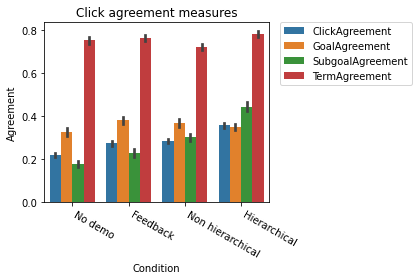

In [8]:
# Click Agreement
dfs = []
for category in ("ClickAgreement", "GoalAgreement", "SubgoalAgreement", "TermAgreement"):
    partial_df = df_after_exclusion[["Condition", category]].copy()
    partial_df.columns = ["Condition", "Agreement"]
    partial_df["Measurement"] = category
    dfs.append(partial_df)
agreement_df = pd.concat(dfs)
ax = sns.barplot(data=agreement_df[~agreement_df["Agreement"].isna()], x="Condition", y="Agreement", hue="Measurement")
_ = ax.set_xticklabels([conditions[x] for x in ax.get_xticks()], rotation=-30, ha='left')
_ = ax.set_title("Click agreement measures")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("./increasing_variance/img/click_agreement.png")

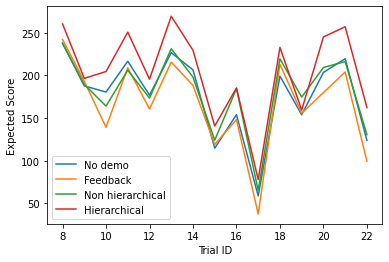

In [9]:
# Plot of scores per condition

score_per_trial = df_after_exclusion.groupby(["Condition", "TrialId"]).mean()[["Score", "ExpectedScore"]]
score_per_trial = score_per_trial.reset_index()


plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==0], label="No demo")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==1], label="Feedback")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==2], label="Non hierarchical")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==3], label="Hierarchical")
plt.xlabel("Trial ID")
plt.ylabel("Expected Score")
plt.legend()

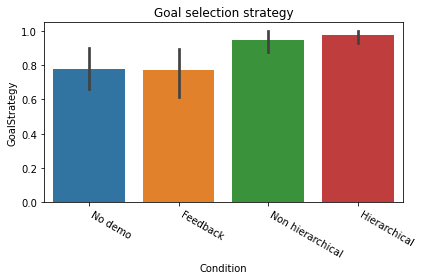

In [10]:
ax = sns.barplot(data=df_after_exclusion.groupby("Participant").median(), x="Condition", y="GoalStrategy")

_ = ax.set_xticklabels([conditions[x] for x in ax.get_xticks()], rotation=-30, ha='left')
plt.title("Goal selection strategy")
plt.tight_layout()
plt.savefig("./increasing_variance/img/goal_strategy.png")

In [11]:
df_after_exclusion.groupby("Participant").median().groupby("Condition").agg(["mean"])["GoalStrategy"]

,mean
Condition,
0.0,0.780488
1.0,0.769231
2.0,0.950000
3.0,0.975610


In [12]:
click_agreement_per_participant = df_after_exclusion.groupby("Participant").mean()[["Condition", "ClickAgreement"]]
click_agreement_per_participant["LearnedStrategy"] = click_agreement_per_participant["ClickAgreement"] > 0.33
click_agreement_per_participant.groupby("Condition").mean()["LearnedStrategy"]

Condition
0.0    0.073171
1.0    0.282051
2.0    0.225000
3.0    0.731707
Name: LearnedStrategy, dtype: float64

In [13]:
df_after_exclusion.groupby("Condition").agg(["mean", "std"])[["ExpectedScore", "ClickAgreement", "GoalAgreement", "SubgoalAgreement", "TermAgreement", "GoalTermAgreement", "SubgoalTermAgreement"]].round(4)

ExpectedScore           ClickAgreement         GoalAgreement  \
                   mean       std           mean     std          mean   
Condition                                                                
0              177.3626   95.0423         0.2208  0.1234        0.3253   
1              167.0222  103.4207         0.2744  0.1269        0.3808   
2              181.5767   93.6312         0.2851  0.1345        0.3702   
3              204.4797   83.1569         0.3584  0.1506        0.3486   

                  SubgoalAgreement         TermAgreement          \
              std             mean     std          mean     std   
Condition                                                          
0          0.2123           0.1782  0.1744        0.7541  0.2077   
1          0.1926           0.2300  0.2211        0.7646  0.1764   
2          0.2250           0.3037  0.2041        0.7213  0.1761   
3          0.1786           0.4445  0.2566        0.7822  0.1771   

          GoalTermAgreement         SubgoalTermAgreement          
                       mean     std                 mean     std  
Condition                                                         
0                    0.7656  0.2663               0.6862  0.2258  
1                    0.7545  0.2448               0.6820  0.2255  
2                    0.7268  0.2761               0.6569  0.2044  
3                    0.8286  0.1984               0.7161  0.2284

Text(0.5, 1.0, 'Hierarchical')

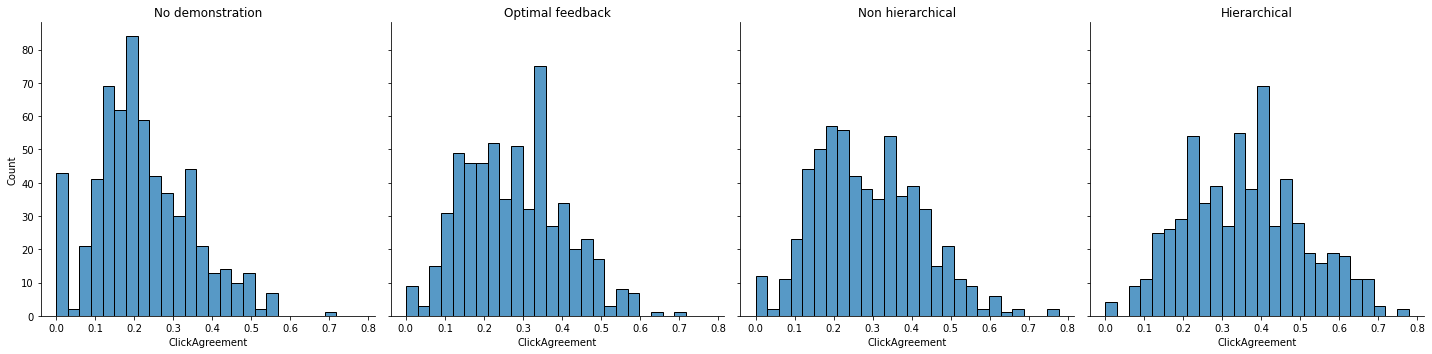

In [14]:
g = sns.displot(data=df_after_exclusion, x="ClickAgreement", col="Condition", facet_kws=dict(margin_titles=True))

axes = g.axes.flatten()
axes[0].set_title("No demonstration")
axes[1].set_title("Optimal feedback")
axes[2].set_title("Non hierarchical")
axes[3].set_title("Hierarchical")

<AxesSubplot:xlabel='Condition', ylabel='ExpectedScore'>

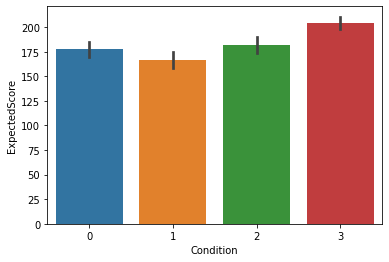

In [15]:
sns.barplot(x="Condition",y="ExpectedScore",data=df_after_exclusion)